In [8]:
import torch
import numpy as np
from tqdm import tqdm
from qai_hub_models.models.ffnet_40s import Model as FFNetModel
import torch
import lightning as L
from torch.nn import functional as F
import os
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import random
from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from typing import Tuple, Optional
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import gc
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import concurrent.futures

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Loading data

In [9]:
mapping_20 = {
        0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 8, 9: 1,
        10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3,
        20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7,
        30: 7, 31: 7, 32: 7, 33: 7, 34: 7
    }

In [10]:
from collections import namedtuple
Label = namedtuple( 'Label' , ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'])

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]


In [11]:
id2color = { label.id : np.asarray(label.color) for label in labels }

In [12]:
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary

    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category

In [15]:
def process_image_mask(image_mask):
    return np.array(image_mask[1])

class ImageDataset(Dataset):
    mapping_20 = {
        0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 8, 9: 1,
        10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3,
        20: 3, 21: 4, 22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7,
        30: 7, 31: 7, 32: 7, 33: 7, 34: 7
    }

    Label = namedtuple( 'Label' , ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'])

    labels = [
        #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
        Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
        Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
        Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
        Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
        Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 8       , False        , False        , (244, 35,232) ),
        Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
        Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
        Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
        Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

        Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
        Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
        Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
        Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
        Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
        Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
        Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
        Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

        Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
        Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
        Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
        Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
        Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
        Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
        Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
        Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
        Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
        Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
        Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
        Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
        Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
        Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]
    
    id2color = { label.id : np.asarray(label.color) for label in labels }

    def __init__(self, path: str, num_classes: int = 8) -> None:
        super().__init__()
        self.num_classes = num_classes
        images, masks = self.load_images(path)
        self.images = images
        self.masks = masks
    
    def __len__(self):
        return min(len(self.images), len(self.masks))
    
    def __getitem__(self, idx: int):
        return self.images[idx], self.masks[idx]

    @staticmethod
    def load_image_mask(path: str):
        img = Image.open(path)
        width, height = img.size

        left_box = (0, 0, width // 2, height)
        right_box = (width // 2, 0, width, height)

        image = img.crop(left_box)
        mask = img.crop(right_box)
        return image, mask
    
    @staticmethod
    def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
        closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
        closest_category = np.full([mask.shape[0], mask.shape[1]], None)

        for id, color in mapping.items(): # iterate over every color mapping
            dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
            is_closer = closest_distance > dist
            closest_distance = np.where(is_closer, dist, closest_distance)
            closest_category = np.where(is_closer, id, closest_category)

        return closest_category

    def one_hot_encode_mask(self, mask):
        one_hot_encoded_mask= np.zeros((self.num_classes, *mask.shape), dtype=int)
        for i in range(self.num_classes):
            one_hot_encoded_mask[i][mask == i] = 1
        
        return one_hot_encoded_mask
    
    def process_mask(self, mask):
        return self.find_closest_labels_vectorized(mask, self.id2color)


    def load_images(self, path: str):
        file_paths = sorted(glob(os.path.join(path, '*jpg')))
        image_masks = list(tqdm(map(lambda p: ImageDataset.load_image_mask(p), file_paths), total=len(file_paths)))
        images = list(tqdm(map(lambda image_mask: np.array(image_mask[0]) / 255, image_masks), total=len(image_masks)))
        
        images = list(tqdm(map(lambda m: m.reshape(3, 256, 256).astype(float), images), total=len(images)))
        masks = list(tqdm(map(lambda image_mask: np.array(image_mask[1]),  image_masks), total=len(image_masks)))
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.process_mask, mask) for mask in masks]
    
            results = [future.result() for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures))]
        
        masks = results
        # masks = list(tqdm(map(lambda m: self.find_closest_labels_vectorized(m, self.id2color), masks), total=len(masks)))
        
        simplify_masks = lambda m: self.mapping_20.get(m, 0)
        simplify_masks_vectorized = np.vectorize(simplify_masks)
        
        masks = list(tqdm(map(lambda m: simplify_masks_vectorized(m), masks), total=len(masks)))
        masks = list(tqdm(map(lambda m: self.one_hot_encode_mask(m).astype(float), masks), total=len(masks)))
        return images, masks

        
train_path = "seg_data/cityscapes_data/train"
val_path = "seg_data/cityscapes_data/val"

train_ds = ImageDataset(train_path)
val_ds = ImageDataset(val_path)


  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
BATCH_SIZE = 4
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

# Model definition

In [17]:
import torch
import torch.nn as nn

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(InvertedResidualBlock, self).__init__()

        self.stride = stride
        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer(out)
        out = self.pointwise_layer(out)

        return out

class InvertedResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=1):
        super(InvertedResidualBlockTranspose, self).__init__()

        self.stride = stride

        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1,
                               output_padding=(0 if stride == 1 else 1), groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer_transpose(out)
        out = self.pointwise_layer_transpose(out)

        return out


class MobileNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super(MobileNetEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            InvertedResidualBlock(32, 16, 1, 1),
            InvertedResidualBlock(16, 24, 6, 2),
            InvertedResidualBlock(24, 24, 6, 1),
            InvertedResidualBlock(24, 32, 6, 2),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 64, 6, 2),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 160, 6, 2),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 320, 6, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [18]:
class EncoderDecoderModel(L.LightningModule):
    def __init__(self, num_classes: int = 3) -> None:
        super().__init__()
        self.num_classes_ = num_classes
        self.encoder = MobileNetEncoder()
        self.encoder_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.encoder_upsample = nn.Upsample(size=(1024, 2048), mode='bilinear', align_corners=False)
        self.decoder = FFNetModel.from_pretrained()
        self.decoder_upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
        # segmentation head
        self.decoder_conv = nn.Conv2d(in_channels=19, out_channels=num_classes, kernel_size=1, stride=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc_output = self.encoder(x)
        enc_output = enc_output[:, 159:162, :, :]
        enc_output = enc_output[:, :, :, :]
        enc_conv = self.encoder_conv(enc_output)
        enc_upsampled = self.encoder_upsample(enc_conv)
        dec_output = self.decoder(enc_upsampled)
        dec_upsampled = self.decoder_upsample(dec_output)
        dec_conv = self.decoder_conv(dec_upsampled)
        output_tensor = torch.sigmoid(dec_conv)
        return output_tensor
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        x, y = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log("train_step_loss", loss.item(), on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log("train_epoch_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.log("val_step_loss", loss.item(), on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log("val_epoch_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    

In [21]:
model = EncoderDecoderModel(num_classes=8)

Loading pretrained model state dict from /home/agorski/.qaihm/models/ffnet/v1/ffnet40S/ffnet40S_dBBB_cityscapes_state_dict_quarts.pth
Initializing ffnnet40S_dBBB_mobile weights


In [22]:
run_id = str(datetime.now())
checkpoint_path = os.path.join('../models', run_id)

os.makedirs(checkpoint_path, exist_ok=True)


checkpoint_callback = ModelCheckpoint(
        every_n_epochs=1,
        save_top_k=-1,
        dirpath=checkpoint_path
    )

In [31]:
def calculate_validation_results(model: L.LightningModule, val_loader: DataLoader, num_batches: Optional[int] = None):
    total_loss = 0.0
    counter = 0
    for batch in tqdm(val_loader, total=num_batches if num_batches else len(val_loader)):
        x, y = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = model.forward(x)
        loss = F.binary_cross_entropy(y_hat, y)
        total_loss += loss.item()
        counter += 1
        if num_batches and counter == num_batches:
            break
    if num_batches:
        avg_loss = total_loss / num_batches
    else:
        avg_loss = total_loss / len(val_loader)
    print(f"Average loss: {avg_loss}")

In [24]:
def calibration(model, num_iteration, dataloader):
  iteration_num = num_iteration
  count = 0
  for batch, _ in tqdm(zip(dataloader, range(num_iteration)), total=num_iteration):
      x, y = batch
      x = x.to(torch.float)
      y = y.to(torch.float)
      model.forward(x)
      count += 1
      del x
      del y
      if count >= iteration_num:
        break
  return model

# Training

In [25]:
MAX_EPOCHS = 3

torch.set_float32_matmul_precision('medium')

trainer = L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[checkpoint_callback], logger=TensorBoardLogger(save_dir='.', name=run_id))
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | encoder          | MobileNetEncoder | 1.8 M 
1 | encoder_conv     | Conv2d           | 84    
2 | encoder_upsample | Upsample         | 0     
3 | decoder          | FFNet40S         | 13.9 M
4 | decoder_upsample | Upsample         | 0     
5 | decoder_conv     | Conv2d           | 160   
------------------------------------------------------
15.7 M    Trainable params
0         Non-trainable params
15.7 M    Total params
62.897    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Tags found: ['train_step_loss', 'epoch', 'val_step_loss', 'val_epoch_loss', 'train_epoch_loss']


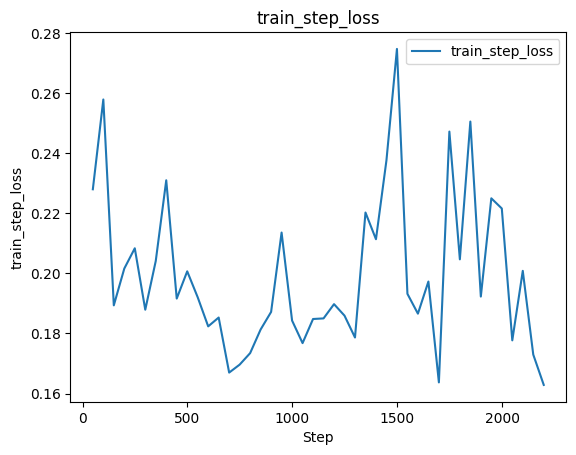

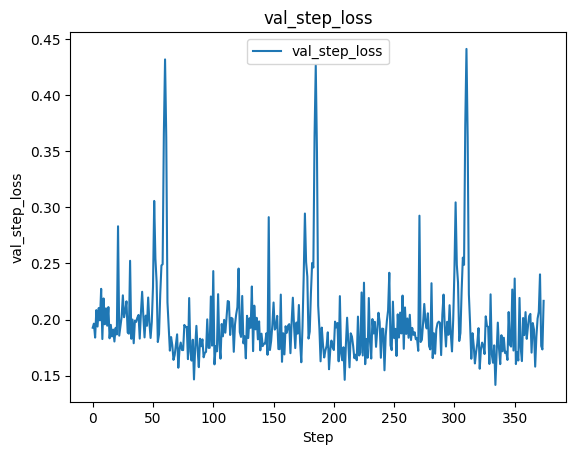

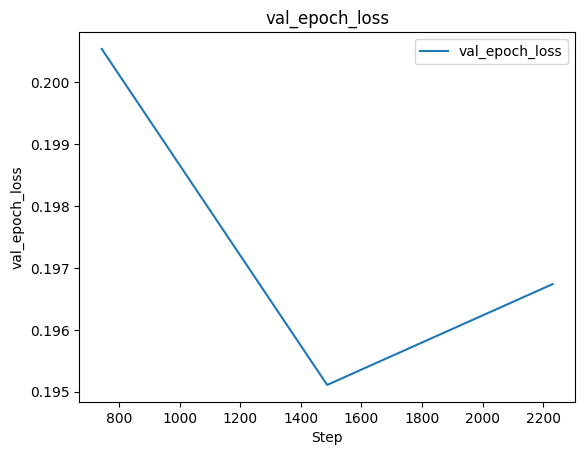

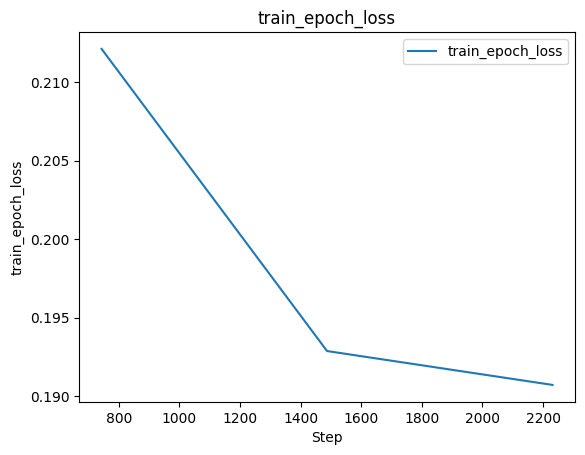

In [26]:
def plot_logs(log_dir):
    log_dir = os.path.join(log_dir, 'version_0')

    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']
    print(f"Tags found: {tags}")

    for tag in tags:
        if tag == 'epoch':
            continue
        events = event_acc.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]

        plt.figure()
        plt.plot(steps, values, label=tag)
        plt.xlabel('Step')
        plt.ylabel(tag)
        plt.title(tag)
        plt.legend()
        plt.show()

plot_logs(run_id)


In [29]:
NUM_BATCHES = 300
NUM_ITERATION = 10

In [32]:
calculate_validation_results(model, val_dl, num_batches=NUM_BATCHES)

  0%|          | 0/300 [00:00<?, ?it/s]

Average loss: 0.08220134720206261


In [33]:
from tinynn.graph.quantization.quantizer import QATQuantizer

quantizer = QATQuantizer(
        model,
        torch.randn(1,3,52,52),
        work_dir='quant_output',
        config={
            'asymmetric': True,
            'backend': 'qnnpack',
            "disable_requantization_for_cat": True,
            'per_tensor': True,
        })

model_with_quantizer = quantizer.quantize()
model_with_quantizer.eval()

QEncoderDecoderModel(
  (fake_quant_0): QuantStub(
    (activation_post_process): FakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (encoder_encoder_0): ConvBn2d(
    3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (weight_fake_quant): FakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): MovingAvera

In [34]:
model_with_quantizer = calibration(model_with_quantizer, NUM_ITERATION, val_dl)
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

16772

In [35]:
calculate_validation_results(model_with_quantizer, val_dl, num_batches=NUM_BATCHES)

  0%|          | 0/300 [00:00<?, ?it/s]

Average loss: 0.09856823389728864


: 